# Project Description

The task is to prepare a prototype of a machine learning model for a company that develops solutions for efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold-bearing ore.
We have data at our disposal with extraction and purification parameters.

The model will help optimize production to avoid running an enterprise with unprofitable characteristics.

# Data description

**Technological process**
* Rougher feed — raw material
* Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    * Xanthate — xanthogenate (promoter, or activator of flotation);
    * Sulphate — sulphate (in this production, sodium sulphide);
    * Depressant — depressant (sodium silicate).
* Rougher process — flotation
* Rougher tails — tailings
* Float banks — flotation unit
* Cleaner process — cleaning
* Rougher Au — rough gold concentrate
* Final Au — final gold concentrate

**Stage parameters

* air amount — volume of air
* fluid levels — fluid level
* feed size — size of raw material granules
* feed rate — feed rate


**The feature naming should be as follows:**  
* [stage].[parameter_type].[parameter_name]
* Example: rougher.input.feed_ag

**Possible values for the [stage] block:**

* rougher — flotation
* primary_cleaner — primary cleaning
* secondary_cleaner — secondary cleaning
* final — final characteristics

**Possible values for the [parameter_type] block:**

* input — raw material parameters
* output — product parameters
* state — parameters characterizing the current state of the stage
* calculation — calculated characteristicsтояние этапа

## Project Structure

1. Data preparation.
    * Study of available files;
    * Verification of enrichment efficiency calculation accuracy;
    * Analysis of features not available in the test sample;
    * Data preprocessing and filling in missing values;
2. Data analysis.
    * Study of how the concentration of metals (Au, Ag, Pb) changes at various cleaning stages;
    * Comparison of raw material granule size distribution in the training and test samples;
    * Research on the total concentration of all substances at different stages: in raw material, in rough and final concentrates.
3. Building a predictive model.
    * Creation of a function to calculate the final sMAPE;
    * Training of different models and evaluating their quality using cross-validation;
    * Selection of the best model and testing its performance on the test sample.
4. Conclusion.

# 1. Data preparation

When preparing the data, we will take the following steps:
* Open files and examine them;
* Verify that the enrichment efficiency is calculated correctly. We will compute it on the training sample for the rougher.output.recovery feature and find the MAE between our computations and the feature value;
* Analyze features not available in the test sample. What kind of parameters are these and what type do they belong to?
* Perform data preprocessing.

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
import joblib

pd.set_option('display.max_columns', 100)

***
## 1.1 Study of available files

The data is located in three files:

* gold_recovery_train.csv — training sample;
* gold_recovery_test.csv — test sample;
* gold_recovery_full.csv — original data

In [2]:
gr_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gr_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gr_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Let's create a function to count the number of missing values in the columns and apply it to each sample.

In [3]:
def miss_inf(data):
    shape_data = data.shape
    miss_data = (data.isnull().sum()/data.shape[0]*100).sort_values(ascending = False).head(15)
    print('The number of rows, columns:', shape_data)
    print()
    print('The share of missing values in the columns (top-15):')
    print(miss_data)

In [4]:
miss_inf(gr_train)

Количество строк, столбцов: (16860, 87)

Доля пропущенных значений в столбцах (топ-15):
rougher.output.recovery                   15.260973
rougher.output.tail_ag                    13.345196
rougher.output.tail_sol                   13.339265
rougher.output.tail_au                    13.339265
secondary_cleaner.output.tail_sol         11.779359
rougher.input.floatbank11_xanthate        11.293001
final.output.recovery                      9.021352
primary_cleaner.input.sulfate              7.752076
primary_cleaner.input.depressant           7.485172
rougher.calculation.au_pb_ratio            7.366548
rougher.input.floatbank10_sulfate          6.192171
primary_cleaner.input.xanthate             5.842230
primary_cleaner.output.concentrate_sol     3.772242
rougher.input.floatbank11_sulfate          3.695136
rougher.state.floatbank10_e_air            3.576512
dtype: float64


In [5]:
miss_inf(gr_test)

Количество строк, столбцов: (5856, 53)

Доля пропущенных значений в столбцах (топ-15):
rougher.input.floatbank11_xanthate          6.028005
primary_cleaner.input.sulfate               5.157104
primary_cleaner.input.depressant            4.849727
rougher.input.floatbank10_sulfate           4.388661
primary_cleaner.input.xanthate              2.834699
rougher.input.floatbank10_xanthate          2.100410
rougher.input.feed_sol                      1.144126
rougher.input.floatbank11_sulfate           0.939208
rougher.input.feed_rate                     0.683060
secondary_cleaner.state.floatbank3_a_air    0.580601
secondary_cleaner.state.floatbank2_b_air    0.392760
rougher.input.feed_size                     0.375683
secondary_cleaner.state.floatbank2_a_air    0.341530
rougher.state.floatbank10_e_air             0.290301
rougher.state.floatbank10_d_air             0.290301
dtype: float64


In [6]:
miss_inf(gr_full)

Количество строк, столбцов: (22716, 87)

Доля пропущенных значений в столбцах (топ-15):
rougher.output.recovery                   13.730410
rougher.output.tail_ag                    12.048776
rougher.output.tail_sol                   12.044374
rougher.output.tail_au                    12.044374
rougher.input.floatbank11_xanthate         9.935728
secondary_cleaner.output.tail_sol          9.750836
final.output.recovery                      8.641486
rougher.calculation.au_pb_ratio            7.162353
primary_cleaner.input.sulfate              7.083113
primary_cleaner.input.depressant           6.805776
rougher.input.floatbank10_sulfate          5.727241
primary_cleaner.input.xanthate             5.066913
primary_cleaner.output.concentrate_sol     3.512942
rougher.input.floatbank11_sulfate          2.984680
rougher.state.floatbank10_e_air            2.729354
dtype: float64


We have 3 samples:

* Full sample - 22716 rows, 87 columns. There are columns with a share of missing values over 10%;
* Training sample - 16860 rows, 87 columns. There are columns with a share of missing values over 10%;
* Test sample - 5856 rows, 53 columns. There are fewer columns than in the other samples.  

Some parameters are not available because they are measured and/or calculated significantly later. That's why some features that can be in the training set are absent in the test sample. There are fewer missing values than in other samples.

Let's study the data types in the columns of the full sample

In [7]:
gr_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

The data type in the date column is object. Let's change it to datetime format

In [8]:
gr_full['date'] = pd.to_datetime(gr_full['date'])
gr_train['date'] = pd.to_datetime(gr_train['date'])
gr_test['date'] = pd.to_datetime(gr_test['date'])

Let's look at the data by printing the first 5 rows of the full sample.

In [9]:
gr_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

We see a lot of negative and zero values for some parameters. We will deal with them later.

***
## 1.2 Checking the accuracy of the enrichment efficiency calculation

For the check, we'll copy the training sample and remove all missing values from there for the formula to work correctly.

In [10]:
gr_train_copy = gr_train.copy()
gr_train_copy.dropna(subset = ['rougher.output.recovery'], inplace = True)

Add a column with our calculation of enrichment efficiency to the table

In [11]:
gr_train_copy['rougher.output.recovery2'] = (
    (gr_train_copy['rougher.output.concentrate_au'] * (gr_train_copy['rougher.input.feed_au'] - 
                                                       gr_train_copy['rougher.output.tail_au'])) /
    (gr_train_copy['rougher.input.feed_au'] * (gr_train_copy['rougher.output.concentrate_au'] - 
                                               gr_train_copy['rougher.output.tail_au'])) * 100
)

Let's calculate the MAE between the given and the calculated value

In [12]:
rougher_output_recovery = pd.Series(gr_train_copy['rougher.output.recovery'])
rougher_output_recovery2 = pd.Series(gr_train_copy['rougher.output.recovery2'])

mean_absolute_error(rougher_output_recovery, rougher_output_recovery2)

9.444891926100695e-15

The MAE metric equals 0, which means that the samples are given correct values.

***
## 1.3 Analysis of features not available in the test sample

Let's find out which parameters are missing in the test sample

In [13]:
set(gr_train.columns)-set(gr_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [14]:
train_colums = gr_train.columns
test_columns = gr_test.columns

mis_columns = []
for col in train_colums:
    if col not in test_columns:
        mis_columns.append(col)
mis_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

The test sample lacks parameters that can only be known after passing all stages of production:

* Product parameters:
    - concentration of useful minerals (gold, silver, lead, lime) in concentrate and tailings after each stage of production;
    - production efficiency coefficient;
* Calculated characteristics;
* Target quantities rougher.output.recovery and final.output.recovery

***
## 1.4 Data preprocessing

We will preprocess the data and fill in the gaps in all features except the target ones.
We will fill in the features by choosing a value from the nearest cell after the gap. 

Let's add the target feature data in the test sample

In [15]:
gr_test_full = gr_test.merge(gr_full.loc[:, ['date', 'rougher.output.recovery', 'final.output.recovery']], 
                             on = 'date', how = 'left')

Before that, we will remove missing values in the target feature in the training and full samples.
We can't leave gaps or fill them with some made-up values because these data can affect the operation of the prediction model and the quality of the prediction in the future

In [16]:
gr_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
gr_test_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
gr_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)

Given that parameters close in time are often similar, we will fill in the gaps in the training and full samples using the ffil method

*Method ffil*

In [17]:
gr_train = gr_train.fillna(method='ffill')
gr_full = gr_full.fillna(method='ffill')
gr_test_full = gr_test_full.fillna(method='ffill')

*After trying to fill in gaps using interpolate*

In [18]:
gr_train = gr_train.interpolate(method ='slinear', limit_direction ='forward')
gr_full = gr_full.interpolate(method ='slinear', limit_direction ='forward')
gr_test_full = gr_test_full.interpolate(method ='slinear', limit_direction ='forward')

In [19]:
miss_inf(gr_train)

Количество строк, столбцов: (14149, 87)

Доля пропущенных значений в столбцах (топ-15):
secondary_cleaner.state.floatbank6_a_level            0.0
rougher.calculation.floatbank10_sulfate_to_au_feed    0.0
primary_cleaner.state.floatbank8_a_level              0.0
primary_cleaner.state.floatbank8_b_air                0.0
primary_cleaner.state.floatbank8_b_level              0.0
primary_cleaner.state.floatbank8_c_air                0.0
primary_cleaner.state.floatbank8_c_level              0.0
primary_cleaner.state.floatbank8_d_air                0.0
primary_cleaner.state.floatbank8_d_level              0.0
rougher.calculation.sulfate_to_au_concentrate         0.0
rougher.calculation.floatbank11_sulfate_to_au_feed    0.0
primary_cleaner.output.tail_au                        0.0
rougher.calculation.au_pb_ratio                       0.0
rougher.input.feed_ag                                 0.0
rougher.input.feed_pb                                 0.0
dtype: float64


In [20]:
miss_inf(gr_test_full)

Количество строк, столбцов: (5290, 55)

Доля пропущенных значений в столбцах (топ-15):
final.output.recovery                       0.0
rougher.input.feed_ag                       0.0
rougher.state.floatbank10_a_level           0.0
rougher.state.floatbank10_a_air             0.0
rougher.input.floatbank11_xanthate          0.0
rougher.input.floatbank11_sulfate           0.0
rougher.input.floatbank10_xanthate          0.0
rougher.input.floatbank10_sulfate           0.0
rougher.input.feed_au                       0.0
rougher.input.feed_sol                      0.0
rougher.input.feed_size                     0.0
rougher.input.feed_rate                     0.0
rougher.input.feed_pb                       0.0
primary_cleaner.state.floatbank8_d_level    0.0
rougher.state.floatbank10_b_level           0.0
dtype: float64


In [21]:
miss_inf(gr_full)

Количество строк, столбцов: (19439, 87)

Доля пропущенных значений в столбцах (топ-15):
secondary_cleaner.state.floatbank6_a_level            0.0
rougher.calculation.floatbank10_sulfate_to_au_feed    0.0
primary_cleaner.state.floatbank8_a_level              0.0
primary_cleaner.state.floatbank8_b_air                0.0
primary_cleaner.state.floatbank8_b_level              0.0
primary_cleaner.state.floatbank8_c_air                0.0
primary_cleaner.state.floatbank8_c_level              0.0
primary_cleaner.state.floatbank8_d_air                0.0
primary_cleaner.state.floatbank8_d_level              0.0
rougher.calculation.sulfate_to_au_concentrate         0.0
rougher.calculation.floatbank11_sulfate_to_au_feed    0.0
primary_cleaner.output.tail_au                        0.0
rougher.calculation.au_pb_ratio                       0.0
rougher.input.feed_ag                                 0.0
rougher.input.feed_pb                                 0.0
dtype: float64


The number of rows of observation objects has decreased, there are no gaps.

Also, as we noticed earlier, the table has features of type .state.floatbank with negative values.
Since we don't have any information about what they should be by default, let's not change them.

***
## Conclusion

At this stage, the following steps were taken:

* Files were loaded and preliminarily studied - 3 samples, training, testing, and full.
Some features are missing in the test sample. All samples have missing values;
* We verified that the enrichment efficiency is calculated correctly. MAE between the given and calculated training sample for the rougher.output.recovery feature is zero;
* We analyzed the features not available in the test sample.
The test sample lacks parameters that can only be known after passing all stages of production:
    * Product parameters:
        * Concentration of useful minerals (gold, silver, lead, lime) in concentrate and tailings after each stage of production;
        * Production efficiency coefficient;
    * Calculation characteristics;
    * Target values rougher.output.recovery and final.output.recovery.
* We preprocessed the data - deleted missing values in the target features and filled the gaps in the rest using the ffil method.*

***
# 2. Data analysis

At this stage, we will perform the following actions:

* Let's see how the concentration of metals (Au, Ag, Pb) changes at different stages of cleaning;
* Let's compare the distribution of raw material granule sizes in the training and test samples;
* We'll explore the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.

***
## 2.1 Change in metal concentration

Let's see how the concentration of metals (Au, Ag, Pb) changes at different cleaning stages.  
For this, we will create a new table, which will only include the columns we need.

In [22]:
#Get a complete list of columns and select only columns with a name that includes 'concentrate'
full_columns = gr_full.columns
col_concentrate = [v for v in full_columns if 'concentrate' in v]
#Delete unnecessary column
col_concentrate.remove('rougher.calculation.sulfate_to_au_concentrate')
#Add to the list columns with information about the concentration in the original rock
col_feed = ('rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au')
col_concentrate.extend(col_feed)
#Create a new dataframe with the columns we need
concentrate = gr_full[col_concentrate]
concentrate.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808,6.100378,2.284912,6.486150
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975,6.161113,2.266033,6.478583
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170,6.116455,2.159622,6.362222
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810,6.043309,2.037807,6.118189
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101,6.060915,1.786875,5.663707


We will create a function for plotting the content of metals (Au, Ag, Pb) at different stages of cleaning.  

In [23]:
def conc(name):
    name_concentrate = [v for v in col_concentrate if name in v]
    name_data = concentrate[name_concentrate]
    name_data.set_axis(['final', 'primary', 'rougher', 'feed'], axis = 'columns', inplace=True)
    name_data = name_data[['feed', 'rougher', 'primary', 'final']]
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=name_data, palette='rainbow', showfliers=False)
    plt.title('Содержание ' + name + ' в концентрате после разных этапов очистки, %')
    plt.show()
    return name_data

We will build graphs for each metal;

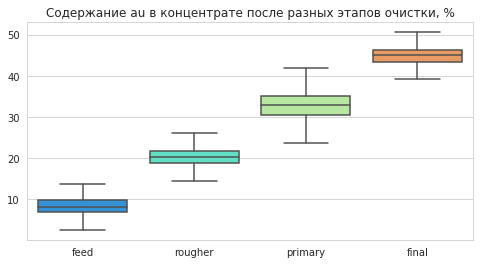

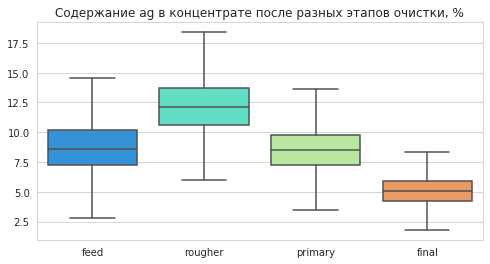

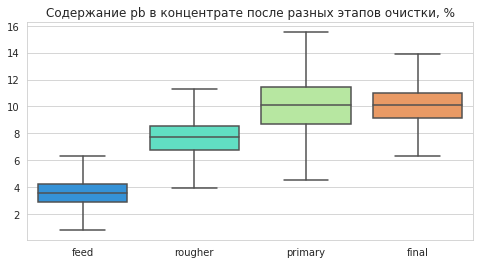

In [25]:
metalls = ['au', 'ag', 'pb']

for cat in metalls:
    conc(cat)

***
### Conclusion

From the obtained graphs, the following conclusions can be made:

* The gold content in the concentrate gradually increases after each cleaning.
In primary ore, the median gold content is less than 10%, in the final concentrate it is about 45%;
* The share of lead also grows, but its share in the final concentrate is equal to the share after primary cleaning.
It can be seen that increasing its share is not the goal of processing;
* The concentration of silver after processing is lower than before it started.

***
## 2.2 Comparison of the distribution of raw material granule sizes in the training and test samples

To compare the distribution of raw material granule sizes in the training and test samples, we will do the following:

* Calculate the confidence interval for the mean value;
* Build histograms of distribution and a box-plot.  

If the distributions differ significantly from each other, the model assessment will be incorrect.

We will calculate the confidence interval for the mean value.

In [26]:
def dov_mean(data):
    print("Cреднее:", data.mean())

    confidence_interval = st.t.interval(0.99, len(data)-1, 
                                    data.mean(), 
                                    data.sem())

    print("99%-ый confidence interval:", confidence_interval)

In [27]:
dov_mean(gr_train['rougher.input.feed_size'])

Cреднее: 60.033540906765616
99%-ый доверительный интервал: (59.533254970921895, 60.533826842609336)


In [28]:
dov_mean(gr_test['rougher.input.feed_size'])

Cреднее: 55.93753506406803
99%-ый доверительный интервал: (55.1709416247278, 56.704128503408256)


The average values ​​are close enough, but the confidence intervals do not intersect, which can be a sign of a significant difference in the size of raw material granules.  
To make a final conclusion, let's look at their distribution.

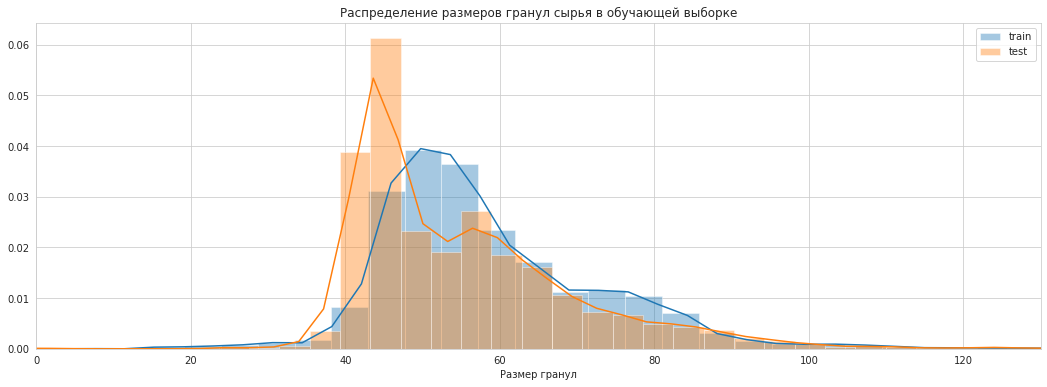

In [29]:
plt.subplots(1, 1, figsize=(18, 6))

plt.title('The distribution of raw material granule sizes in training sample')
plt.xlim(0,130)

sns.distplot(gr_train['rougher.input.feed_size'], kde=True, bins=100, label="train")
sns.distplot(gr_test_full['rougher.input.feed_size'], kde=True, bins=100, label="test")

plt.xlabel('Granule sizes')
plt.legend()
plt.show()

The distribution in both samples is normal, in the test sample the data skew to the left is slightly stronger, but in general the distributions are similar.  
  
Let's build box-plot graphs.

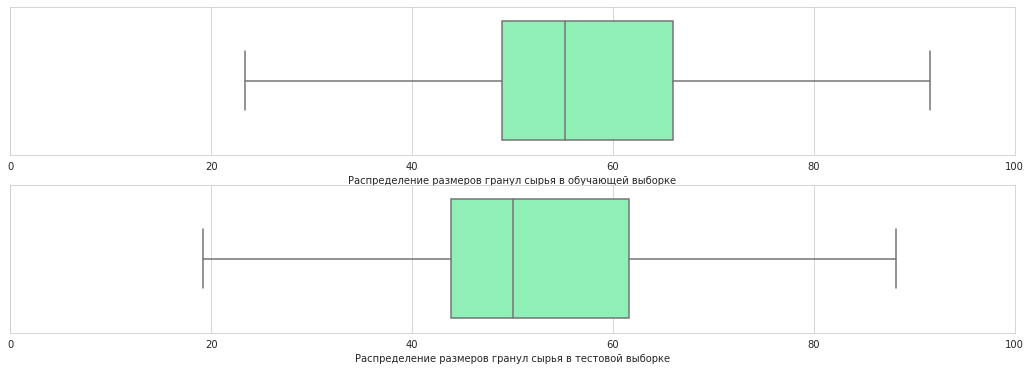

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(18, 6))

axes[0].set_xlim(0,100)
sns.boxplot(data=gr_train, x='rougher.input.feed_size', palette='rainbow', showfliers=False, ax=axes[0])
axes[0].set_xlabel('The distribution of raw material granule sizes in training sample')

axes[1].set_xlim(0,100)
sns.boxplot(data=gr_test, x='rougher.input.feed_size', palette='rainbow', showfliers=False, ax=axes[1])
axes[1].set_xlabel('The distribution of raw material granule sizes in test sample')
plt.show()

Despite the fact that the average granule sizes are different, their distribution parameters in the training and testing samples are almost identical

***
### Conclusion

The distributions of raw material granule sizes differ, but not too much - in general, their distributions are similar.  
  
Further training of the model can be carried out on the existing data.

***
## 2.3 Investigation of the total concentration of all substances at different stages

We will study the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.  
  
To do this, we sum up the data on the content of gold (au), silver (ag), lead (pb) and lime (sol) in raw materials, in rough and final concentrates.

In [31]:
def sum_conc(data):
    data['rougher.input.feed_sum'] = (
    data['rougher.input.feed_ag'] + data['rougher.input.feed_au']
    + data['rougher.input.feed_sol'] + data['rougher.input.feed_pb']
)   
    
    data['rougher.output.concentrate_sum'] = (
    data['rougher.output.concentrate_ag'] + data['rougher.output.concentrate_au']
    + data['rougher.output.concentrate_sol'] + data['rougher.output.concentrate_pb']
) 
    
    data['final.output.concentrate_sum'] = (
    data['final.output.concentrate_ag'] + data['final.output.concentrate_au']
    + data['final.output.concentrate_sol'] + data['final.output.concentrate_pb']
) 

In [32]:
sum_conc(gr_full)
gr_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.input.feed_sum,rougher.output.concentrate_sum,final.output.concentrate_sum
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,51.680034,66.424950,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5

In [33]:
def graph_conc(data):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].set_title('Raw')
    axes[0, 0].set_ylim(0,100)
    sns.boxplot(y = 'rougher.input.feed_sum', data=data, palette='rainbow', ax = axes[0, 0])
    axes[0, 0].set_ylabel('Concentration')
    
    axes[0, 1].set_title('Semi-finished product')
    axes[0, 1].set_ylim(0,100)
    sns.boxplot(y = 'rougher.output.concentrate_sum', data=data, palette='rainbow', ax = axes[0, 1])
    axes[0, 1].set_ylabel('Concentration')
    
    axes[0, 2].set_title('Final solution')
    axes[0, 2].set_ylim(0,100)
    sns.boxplot(y = 'final.output.concentrate_sum', data=data, palette='rainbow', ax = axes[0, 2])
    axes[0, 2].set_ylabel('Concentration')
    
    axes[1, 0].set_title('Raw')
    sns.distplot(data['rougher.input.feed_sum'], kde=False, bins=50, ax = axes[1, 0])
    axes[1, 0].set_xlabel('Concentration')
        
    axes[1, 1].set_title('Semi-finished product')
    sns.distplot(data['rougher.output.concentrate_sum'], kde=False, bins=50, ax = axes[1, 1])
    axes[1, 1].set_xlabel('Concentration')
    
    axes[1, 2].set_title('Final solution')
    sns.distplot(data['final.output.concentrate_sum'], kde=False, bins=50, ax = axes[1, 2])
    axes[1, 2].set_xlabel('Concentration')
    
    plt.show()

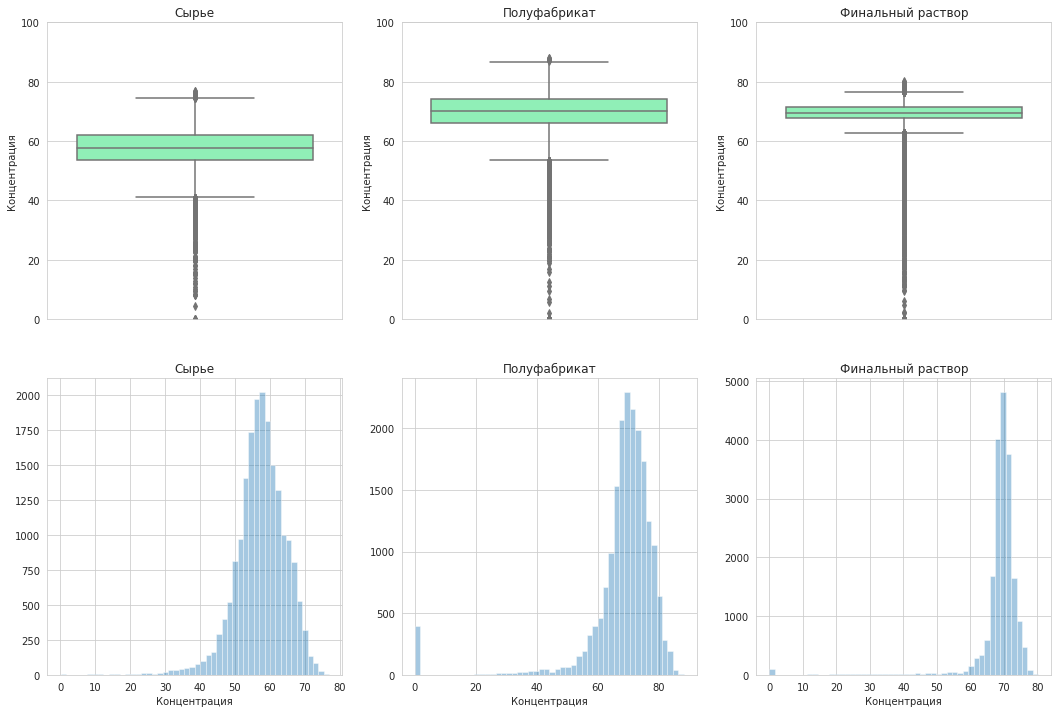

In [34]:
graph_conc(gr_full)

 In the total distribution, we see a large number of outliers.
Most of them are below the lower whisker of the graph at each production stage.

We will remove outliers in the full sample.

In [35]:
gr_full_good = (
    gr_full[(gr_full['rougher.input.feed_sum'] > gr_full['rougher.input.feed_sum'].quantile(0.01))&
           (gr_full['rougher.output.concentrate_sum'] > gr_full['rougher.output.concentrate_sum'].quantile(0.01))&
           (gr_full['final.output.concentrate_sum'] > gr_full['final.output.concentrate_sum'].quantile(0.01))]
)

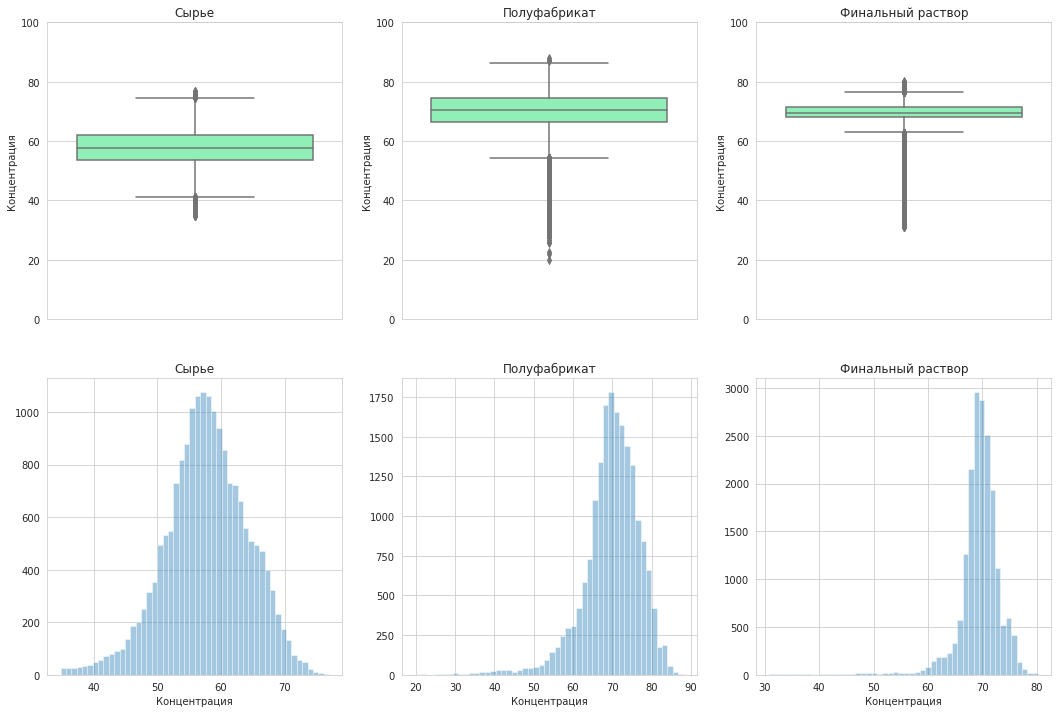

In [36]:
graph_conc(gr_full_good)

We will remove from the training and test samples the objects removed from the full sample.

In [37]:
# create a list of dates for the full sample
gr_full_good_dates = list(gr_full_good['date'])
# create columns indicating the presence of the object's date in the full sample
gr_train.loc[gr_train['date'].isin(gr_full_good_dates), 'index'] = 1
gr_train.loc[~gr_train['date'].isin(gr_full_good_dates), 'index'] = 0
gr_test_full.loc[gr_test_full['date'].isin(gr_full_good_dates), 'index'] = 1
gr_test_full.loc[~gr_test_full['date'].isin(gr_full_good_dates), 'index'] = 0
# remove missing objects
gr_train_good = gr_train[gr_train['index'] == 1]
gr_test_good = gr_test_full[gr_test_full['index'] == 1]
gr_test_good = gr_test_good.fillna(method='ffill')
print(gr_train_good.shape)
print(gr_test_good.shape)

(13602, 88)
(5097, 56)


***
### Conclusion

In the total distribution of all substances at different stages, there are many outliers that can affect further prediction models.  
All zero and near-zero outliers were removed from the full sample.  
Corresponding objects were also removed from the training and test samples.  

***
## Conclusion

At this stage, we carried out the following actions:

* We looked at how the concentration of metals (Au, Ag, Pb) changes at different stages of purification - the concentration of gold steadily increases. The concentration of silver in the final concentrate is lower than in the raw material. The share of lead increases after primary purification, but then does not change.
* We compared the distributions of raw material granule sizes in the training and test samples - the distributions are similar;
* We studied the total concentration of all substances at different stages: in raw materials, in rough and final concentrates - the total concentration grows slightly after primary raw material processing. There are many outliers in the distribution. We removed some of them from all samples.

# 3. Building a predictive model

At this stage, we will perform the following steps:

* Write a function for calculating the final sMAPE;
* Train different models and assess their quality with cross-validation;
* Select the best model and test it on the test sample.

***
## 3.1. Function for calculating sMAPE

We will build a function for calculating the sMAPE metric - symmetric mean absolute percentage deviation.  
It is similar to MAE, but it is expressed not in absolute values, but in relative ones, i.e., it takes into account the scale of both the target feature and the prediction in the same way.

In [58]:
def smape_np(target, predict):
    target = pd.Series(target)
    predict = pd.Series(predict)
    return ((abs(target-predict)/((abs(target)+abs(predict))/2)).sum(skipna=True)/target.shape[0]*100)

Let's check the correctness of our function and create two lists of data and calculate the sMAPE metric for them manually and using the function.

In [60]:
data_train1 = np.array([1, 1, 3, 3, 0])
data_predict1 = np.array([1, 2, 4, 3, 0])

y = (
    (abs(1 - 1) / ((abs(1) + abs(1)) / 2)) + 
    (abs(1 - 2) / ((abs(1) + abs(2)) / 2)) +
    (abs(3 - 4) / ((abs(3) + abs(4)) / 2)) + 
    (abs(3 - 3) / ((abs(3) + abs(3)) / 2)) 
      )

smape_y = (y / 5) * 100


print('Manual calculation result: sMAPE = ', smape_y)
print('Function calculation result: sMAPE = ', smape_np(data_train1, data_predict1))

Результат расчета вручную: sMAPE =  19.047619047619047
Результат расчета функцией: sMAPE =  19.047619047619047


The results are identical, so the function works correctly.

***
## 3.2 Model training

At this stage, we will prepare data for training various predictive models, train the models and select the best one

***
### Encoding of categorical features to numerical

For training our future models, we need to convert columns with categorical data into quantitative ones.  
In our database, there is only one column with categorical data - date.  
  
To predict the concentration of gold after ore processing, we do not need information about the time and date of processing, so we will   delete the column with this information and separate the target feature into separate tables.  
  
We will also remove from the training sample columns that are absent in the test sample  

In [40]:
features_train_f = gr_train_good.drop(['date', 'index'], axis=1)
features_train_full = features_train_f.drop(mis_columns, axis=1)
target_train_full = gr_train_good[['rougher.output.recovery', 'final.output.recovery']]

features_test = gr_test_good.drop(['date', 'index', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = gr_test_good[['rougher.output.recovery', 'final.output.recovery']]

In [41]:
print(features_train_full.shape)
print(features_test.shape)

(13602, 52)
(5097, 52)


***
### Scaling of quantitative features

Now we will scale the quantitative features using the Standardization method.  
Standardization implies such preprocessing of data, after which each feature has a mean of 0 and a variance of 1.  
We will first check the distribution of feature values in the training sample and create a standardization function.  

In [42]:
features_train_full.describe().round(4)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000
mean,134.3282,8.8799,7.3277,0.8859,1607.4287,-488.6369,1608.1445,-489.0410,1608.4488,-489.4434,1540.6432,-483.4184,8.6039,3.5179,477.2175,59.7935,36.5272,7.8893,11.7383,5.8923,11.3822,5.8109,1123.8053,-370.4208,1322.8660,-464.3194,1301.8590,-465.1296,1212.8887,-465.5378,1090.5112,-464.9843,1036.9443,-464.7188,29.7383,-501.8618,24.9367,-503.2726,29.2808,-478.0683,22.6852,-488.7708,20.0315,-478.4273,15.5258,-460.6921,16.8374,-483.8584,13.1157,-483.8525,19.6667,-506.8119
std,38.8084,3.3607,0.6131,0.3756,128.9859,35.8294,131.8198,33.6758,134.0086,35.5666,279.3717,46.1165,1.8603,1.0799,100.9009,21.8311,4.4324,1.8921,3.2060,1.0670,3.6771,1.2980,168.7455,94.2978,181.7712,57.1479,212.0163,55.5977,208.6711,55.4019,186.0756,56.3221,174.8933,56.3594,5.7921,59.4478,5.9909,62.2827,5.6487,54.6227,5.0026,42.0176,5.6889,50.4601,5.2715,58.2852,5.8367,38.1121,5.7878,38.7605,5.7327,36.6671
min,0.0031,0.0000,1.0800,0.0000,0.0064,-798.6417,0.0087,-740.1221,0.0152,-799.8031,0.0087,-799.7886,3.4665,0.0886,0.0128,9.6596,13.6245,0.5882,0.0012,0.0014,0.0002,0.0003,-0.0411,-650.2029,-0.6534,-650.2600,-0.0351,-640.9956,-0.5543,-640.5190,-1.9703,-649.4439,-2.4306,-649.8810,0.0775,-799.6064,0.0000,-799.8739,0.0000,-799.6130,0.0000,-759.1774,0.0000,-799.7068,0.0000,-799.8608,-0.3721,-797.1425,0.6462,-800.0062,0.1953,-809.3987
25%,108.3998,6.0451,6.9604,0.6083,1594.8292,-500.2842,1552.8447,-500.3732,1548.9595,-500.5955,1451.3437,-500.4538,7.1401,2.7774,428.3126,48.9764,34.1812,6.6097,9.8686,5.1984,9.5429,5.1442,999.7954,-499.8027,1199.4758,-500.1823,1103

The average value of each feature is greater than 0, the variance values are also not equal to 1

In [43]:
def scalers(train, test):
    numeric = train.columns
    scaler = StandardScaler()
    scaler.fit(train[numeric])
    train[numeric] = scaler.transform(train[numeric])
    test[numeric] = scaler.transform(test[numeric])

In [44]:
scalers(features_train_full, features_test)

In [45]:
features_train_full.describe().round(4)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000,13602.0000
mean,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-3.4614,-2.6424,-10.1914,-2.3584,-12.4625,-8.6526,-12.1999,-7.4561,-12.0029,-8.7265,-5.5148,-6.8605,-2.7617,-3.1759,-4.7296,-2.2965,-5.1672,-3.8589,-3.6611,-5.5211,-3.0955,-4.4767,-6.6603,-2.9671,-7.2815,-3.2538,-6.1408,-3.1633,-5.8153,-3.1585,-5.8714,-3.2752,-5.9431,-3.2855,-5.1211,-5.0087,-4.1626,-4.7624,-5.1838,-5.8869,-4.5348,-6.4358,-3.5213,-6.3672,-2.9453,-5.8193,-2.9486,-8.2204,-2.1545,-8.1569,-3.3966,-8.2526
25%,-0.6681,-0.8436,-0.5991,-0.7391,-0.0977,-0.3251,-0.4195,-0.3365,-0.4439,-0.3136,-0.3197,-0.3694,-0.7869,-0.6857,-0.4847,-0.4955,-0.5293,-0.6763,-0.5832,-0.6503,-0.5002,-0.5136,-0.7349,-1.3721,-0.6788,-0.6276,-0.9351,-0.6310,-0.7258,-0.6285,-0.5844,-0.6261,-0.7751,-0.6344,-0.7984,0.0272,-0.4796,0.0483,-0.7595,-0.4047,-0.5492,-0.2699,-0.8859,-0.4399,-0.6862,-0.

The average values of all features are equal to 0, the variance of all features is equal to 1.  
The standardization was successful.

We will also create a training sample to predict the values of the target feature rougher.output.recovery

In [47]:
features_train_columns = features_train_full.columns
col_rougher = [v for v in features_train_columns if 'rougher' in v]
features_train_rougher = features_train_full[col_rougher]
features_test_rougher = features_test[col_rougher]
features_test_rougher

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,2.432332,1.962185,0.124643,0.133618,1.239812,2.217100,1.617199,0.244739,1.491815,0.261824,-0.722748,0.213370,-0.402319,1.141150,-0.245785,1.182338,-0.069973,1.192227,-0.489276,1.162168,-0.499627,1.180645
1,2.382720,1.859719,0.127724,0.099295,1.051526,2.129826,1.642046,0.099998,1.526774,0.147495,-0.741466,0.212050,-0.409709,1.126477,-0.246898,1.178128,-0.059341,1.184035,-0.486428,1.162868,-0.496002,1.045672
2,2.437623,1.767569,0.122902,0.325707,1.358002,2.220921,1.638923,-0.039097,1.522976,0.032914,-0.742498,0.218860,-0.414961,1.120907,-0.253064,1.152162,-0.062870,1.168725,-0.486840,1.167388,-0.495314,1.133028
3,2.040948,1.478813,-0.005940,0.003316,1.022713,2.268629,1.495319,-0.084737,1.396017,-0.005559,-0.732068,0.214734,-0.393604,1.149064,-0.242279,1.176043,-0.064650,1.228067,-0.476063,1.146071,-0.492942,1.151861
4,1.464095,1.157115,0.109325,0.161326,1.069859,1.797616,0.582970,-0.144582,0.616778,-0.054884,-0.754205,0.210599,-0.100169,1.134081,0.021681,1.188563,0.171619,1.167168,-0.170217,1.171805,-0.499174,1.161183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,1.631572,1.090365,0.440722,0.319049,1.239719,1.408679,-0.508167,1.229252,-0.345776,1.068831,1.636429,0.746823,-1.503176,-0.625689,-1.650571,-0.620896,-1.727908,-0.594346,-1.284871,-0.626798,-1.060588,-0.621336
5852,1.469828,0.889474,0.525072,0.126757,1.030876,1.249858,-0.548624,1.226403,-0.381658,1.071748,1.673095,0.756818,-1.469763,-0.593758,-1.627335,-0.580518,-1.713295,-0.544494,-1.281461,-0.611833,-1.061345,-0.565339
5853,1.441775,0.821820,0.684750,0.634621,1.030675,1.204956,-0.485389,1.222055,-0.325469,1.069220,1.614311,0.744585,-1.512871,-0.617453,-1.664535,-0.619111,-1.708795,-0.623790,-1.289290,-0.612382,-1.067346,-0.599559
5854,1.443819,0.764551,0.694905,0.837043,1.170615,1.153193,-0.314236,1.225619,-0.178366,1.070883,1.660176,0.746500,-1.502294,-0.620801,-1.656017,-0.633952,-1.750386,-0.620626,-1.295748,-0.628483,-1.068515,-0.634512


***
### Model training

In this research, we face a regression task, i.e., finding the value of a quantitative feature.  
We will create a function for predicting the proportion of gold in concentrates at different stages of purification.  
Through cross-validation, we will get 5 sMAPE metric results for each model and find the average value.  

In [61]:
def ml_model(ML, ftr, ftf, tt):

    smape_scorer = make_scorer(smape_np, greater_is_better=False)

    cross_val_score_rougher = cross_val_score(ML, ftr, tt['rougher.output.recovery'], cv=2,
                                          scoring = smape_scorer).mean()
    cross_val_score_final = cross_val_score(ML, ftf, tt['final.output.recovery'], cv=2,
                                        scoring = smape_scorer).mean()

    smape_total = 0.25*cross_val_score_rougher + 0.75*cross_val_score_final

    print('smape_total =', smape_total)  

**Building a prediction using a Linear Regression model**

In [62]:
ml_model(LinearRegression(), features_train_rougher, features_train_full, target_train_full)

smape_total = -4.846048502943279


**Building a prediction using a Decision tree model**

In [63]:
ml_model(DecisionTreeRegressor(random_state=12345), features_train_rougher, features_train_full, target_train_full)

smape_total = -7.093813077092988


**Building a prediction using a Random forest model**

In [64]:
ml_model(RandomForestRegressor(random_state=12345), 
         features_train_rougher, features_train_full, target_train_full)

smape_total = -4.729023046221231


**ПBuilding a prediction using a KNN model**

In [65]:
ml_model(KNeighborsRegressor(n_neighbors=10), features_train_rougher, features_train_full, target_train_full)

smape_total = -4.495762221385602


***
### Conclusion

At the preliminary stage, the best result was shown by the Random Forest model;  
  
In the next step, we will try to adjust the hyperparameters of this model and select the best ones. 

***
### Selection of hyperparameters values

Let's build a Random Forest model and check the prediction results at different numbers of trees.

In [66]:
for estimator in range(10, 52, 10):
    print('n_estimators:', estimator)
    ml_model(RandomForestRegressor(n_estimators=estimator, random_state=12345), 
         features_train_rougher, features_train_full, target_train_full)  

n_estimators: 10
smape_total = -4.729023046221231
n_estimators: 20
smape_total = -4.5972393713058155
n_estimators: 30
smape_total = -4.546673758216738
n_estimators: 40
smape_total = -4.504392250247067
n_estimators: 50
smape_total = -4.517939995272288


The best result with 50 trees, sMAPE is:  

* first variant - 10.22 - smape function through numpy, filling gaps with ffil  
* second variant - 10.18 - smape function through numpy, filling gaps with interpolate linear  
* third variant - 4.51 - smape function with removing zeros from the denominator, filling gaps with interpolate linear

Now let's check at which tree depth the best result will be obtained.

In [67]:
for depth in range(1, 8):
    print('max_depth:', depth)
    ml_model(RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=12345), 
         features_train_rougher, features_train_full, target_train_full)  

max_depth: 1
smape_total = -4.279760967994916
max_depth: 2
smape_total = -4.2668535821005165
max_depth: 3
smape_total = -4.27625239728646
max_depth: 4
smape_total = -4.346293662407821
max_depth: 5
smape_total = -4.378832100975247
max_depth: 6
smape_total = -4.3370113334849
max_depth: 7
smape_total = -4.370888967367613


The best result at a depth of 2, sMAPE equals 9.20 / 9.20 / 4.26

We will select the optimal number of max_features

In [70]:
for features in range(1, 5):
    print('max_features:', features)
    ml_model(RandomForestRegressor(n_estimators=50, max_depth=2, max_features=features, random_state=12345), 
         features_train_rougher, features_train_full, target_train_full)

max_features: 1
smape_total = -3.805170597739699
max_features: 2
smape_total = -3.8143272521629132
max_features: 3
smape_total = -3.9140346532751233
max_features: 4
smape_total = -3.9157269164320185


he best result with max_features equal to 17, sMAPE равен 9.15 / 9.18 / 3.80

***
### Conclusion

The Random Forest model with the best results was the model with tree depth of 3, the number of trees 40, max_features indicator 4.  
The sMAPE indicator of this model in cross-validation is 9.15

## 3.3 Testing the model on a test sample

Let's check the model on a test sample

In [71]:
rfr_rougher = RandomForestRegressor(n_estimators=50, max_depth=2, max_features=17, random_state=12345)
rfr_final = RandomForestRegressor(n_estimators=50, max_depth=2, max_features=17, random_state=12345)

rfr_rougher.fit(features_train_rougher, target_train_full)
rfr_final.fit(features_train_full, target_train_full)

predictions_test_rougher = rfr_rougher.predict(features_test_rougher)
predicted_test_rougher = pd.DataFrame(predictions_test_rougher)

predictions_test_final = rfr_final.predict(features_test)
predicted_test_final = pd.DataFrame(predictions_test_final)
    
smape_rougher = smape_np(target_test['rougher.output.recovery'], predicted_test_rougher[0])
smape_final = smape_np(target_test['final.output.recovery'], predicted_test_final[1])

smape_total = 0.25*smape_rougher + 0.75*smape_final

print('smape_total =', smape_total)

smape_total = 5.9880176075271425


### Model adequacy check

Filling targets with average values

In [72]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train_full, target_train_full)

target_pred = dummy_regr.predict(target_test)
target_pred_df = pd.DataFrame(target_pred)

smape_rougher_dummy = smape_np(target_pred_df[0], target_test['rougher.output.recovery'])
smape_final_dummy = smape_np(target_pred_df[1], target_test['final.output.recovery'])

smape_total = 0.25*smape_rougher_dummy + 0.75*smape_final_dummy
smape_total

6.259821798068184

***
## Conclusion

The model passed the adequacy check. We can start putting it into operation and start the process of refinement after receiving the first results.

***
# Overall conclusion

In this project, we studied data from a gold mining company, which contained information about all stages of processing gold-bearing ore, and developed a model predicting the recovery rate of gold from gold-bearing ore.

The following steps were carried out for this:

* Data preparation:
    * Files - 3 samples, training, test, full - were loaded and initially studied.
    * The calculation of enrichment efficiency was checked. MAE between the given and calculated training sample for the feature rougher.output.recovery is zero;
    * We analyzed the features that are not available in the test sample;   
    In the test sample, there are no parameters that can be learned only after passing all stages of production:
    * Data preprocessing was carried out - missing values in target features were removed and gaps in others were filled using the ffil method.
* The change in the concentration of metals (Au, Ag, Pb) at different stages of purification was studied.
    * The concentration of gold systematically increases. The concentration of silver in the final concentrate is lower than in the raw material. The share of lead increases after primary cleaning, but then does not change.
* The comparison of the distribution of raw material grain sizes in the training and test samples was carried out - the distributions are similar;
* The total concentrations of all substances at different stages were studied: in raw materials, in rough and final concentrates.
    * The total concentration grows slightly after the primary raw material treatment. Some outliers were removed from all samples.
* Data for forecasting was prepared - scaling was carried out, columns missing in the test sample were removed from the training sample;
* Preliminary training of models was carried out. The best model turned out to be - Random Forest;
* The model's hyperparameters were selected;
* * Forecasting was carried out on the test sample. The results obtained are better than on the training sample;
An adequacy check of the model was carried out - the model did not pass it. Filling target features with average values turned out to be a better strategy with less sMAPE.

***
# Summary

The best model was the RandomForest model with parameters n_estimators=50, max_depth=2, max_features=17.  
  
The best sMAPE result is 5.99.